In [554]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
from scipy.optimize import minimize
from numpy.linalg import inv, slogdet
import pandas as pd

warnings.filterwarnings('ignore')
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")

In [6]:
class KalmanFilter:
    def __init__(self, A, B, Q, H, G, R):
        """
        상태-공간 모형 매개변수를 초기화함
        
        Parameters
        ----------
        A : array of N x N
        B : array of N
        Q : array of N X N
        H : array of M X N
        R : array of M X M
        (N : 상태(벡터)공간의 차원, M : 측정공간의 차원)
        
        """
        self.A = A
        self.B = B
        self.Q = Q
        self.H = H
        self.R = R
        
        self.m, self.n = H.shape
    
    def predict(self, x, P):
        A, B, Q = self.A, self.B, self.Q
        x_pred = A@x+B
        P_pred = A@P@A.T+Q
        return x_pred, P_pred
    
    def update(self, x_pred, P_pred, z_meas):
        H, R = self.H, self.R
        z_pred = H@x_pred
        v = z_meas-z_pred
        F = H@P_pred@H.T+R
        K = P_pred@H.T@inv(F)
        x_update = x_pred+K@v
        P_update = P_pred-K@H@P_pred
        dF = det(F)
        if dF <= 0:
            dF = 1e-70
            print('Warning : dF <= 0 인 경우가 있습니다.')
        logL = -0.5*np.log(2*np.pi)-0.5*np.log(dF)-0.5*v.T@inv(F)@v
        return x_update, P_update, logL
    
    def setInitState(self, x0, P0):
        """
        상태-공간 모형의 초기 상태 및 공분산 행렬 설정
        
        Parameters
        ----------
        x0 = array of N
        P0 = array of N x N
        (N : 상태공간의 차원)
        
        """
        self.x0 = x0
        self.P0 = P0
    
    def setData(self, data):
        """
        Loglikelihood 계산을 위한 기초데이터 입력
        
        Parameters
        ----------
        data = array of T x M
        (T : 데이터의 길이, M : 측정공간의 차원)
        
        """
        self.data = data
        self.t = data.shape[0]
    
    def calcStates(self):
        """
        상태, 공분산, Log-likelihood 계산
               
        Notes
        -----
        실행 전에 기초데이터/초기상태가 미리 설정되어 있어야 함(setData, setInitState)
        
        """
        x, P, data = self.x0, self.P0, self.data
        self.x_stack, self.P_stack, self.loglik_stack = [], [], []
        for i in range(self.t):
            x_pred, P_pred = self.predict(x, P)
            x, P, loglik = self.update(x_pred, P_pred, data[i])
            self.x_stack.append(x)
            self.P_stack.append(P)
            self.loglik_stack.append(loglik)
    
    def getLoglik(self):
        """
        (minus) Log-likelihood 합 계산
        
        Returns
        -------
        (minus) Log-likehilood : double
               
        Notes
        -----
        실행 전에 상태가 미리 계산되어 있어야 함(calcStates)
        
        """
        self.calcStates()
        return -sum(self.loglik_stack)
    
    def genStates(self, x, period=1):
        A, B, Q = self.A, self.B, self.Q
        x_gen = []
        
        for i in range(period):
            x = A@x+B+np.random.multivariate_normal(mean=np.zeros(self.n), cov=Q)
            x_gen.append(x)
        return x_gen
    
    def genMeasurement(self, x):
        H, G, R = self.H, self.G, self.R
        z = H@x+G+np.random.multivariate_normal(mean=np.zeros(self.m), cov=R)
        return z
    
    def objFunc(self, params):
        kf.setParams(params)
        logL = kf.getLoglik()
        return logL
        
    def estimation(self):
        rst = minimize(fun=self.objFunc, x0=self.params, method='nelder-mead', options={'dist':True, 'maxiter':5000})
        return rst

In [7]:
class DNS(KalmanFilter):
    def __init__(self, params, tau, dt):
        """
        DNS 초기 모수, 입력 금리데이터 만기, 입력 데이터 단위(일, 주, 월 등) 이용해 초기화
        
        Parameters
        ----------
        params : list of double
                 λ, α1, α2, α3, μ1, μ2, μ3, σ11, σ22, σ33 입력
        tau : list of double
              입력 금리데이터의 만기들을 리스트로 하여 입력
        dt : double
             입력 금리데이터 단위(예 : 주=1/52, 일=1/250, 월=1/12 등) 입력
             
        Notes
        -----
        [tau의 길이] = [금리데이터의 1 레코드의 길이] = [측정공간의 차원(M)] 이어야 함
        
        """
        self.tau = tau
        self.dt = dt
        self.setParams(params)
        
    def setParams(self, params):
        """
        DNS 모형 매개변수를 상태-공간 모형 형식에 맞게 설정함
        
        Parameters
        ----------
        params : double
                 λ, ε, κ1, κ2, κ3, θ1, θ2, θ3, σ11, σ22, σ33 입력
        
        """
        self.params = params
        lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma11, sigma22, sigma33 = params
        dt, tau = self.dt, self.tau
        
        A = np.array([[1-kappa1*dt, 0, 0],
                      [0, 1-kappa2*dt, 0],
                      [0, 0, 1-kappa3*dt]])
        B = np.array([kappa1*theta1*dt, kappa2*theta2*dt, kappa3*theta3*dt])
        Q = np.array([[sigma11**2, 0, 0],
                      [0, sigma22**2, 0],
                      [0, 0, sigma33**2]])
        H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
        G = np.zeros(len(tau))
        R = np.identity(len(tau))*eps**2
        
        super().__init__(A, B, Q, H, G, R)

In [657]:
# 데이터
data = np.array(pd.read_csv('./data/test/internal_data.csv'))

# 모수
lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma11, sigma22, sigma33 = \
    5e-1+0.01,  3e-4,  2e-2,  1e-3, -8e-1, -2e-1, -1e0, -1e-2, 2e-4,  2e-4,  6e-4
# lambda_ += 1e-4
dt = 1/250
tau = np.array([0.25, 0.5, 0.75 ,1 , 1.5, 2, 2.5, 3, 4, 5, 7, 10, 20])

# 행렬
A = np.array([[1-kappa1*dt, 0, 0],
                      [0, 1-kappa2*dt, 0],
                      [0, 0, 1-kappa3*dt]])
B = np.array([kappa1*theta1*dt, kappa2*theta2*dt, kappa3*theta3*dt])
Q = np.array([[sigma11**2, 0, 0],
              [0, sigma22**2, 0],
              [0, 0, sigma33**2]])
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
G = np.zeros(len(tau))
R = np.identity(len(tau))*eps**2

In [102]:
# Inputs
x_update = np.array([1,1,1])
P_update = np.identity(3)
dx_update_dlambda = np.zeros(3)
dP_update_dlambda = np.zeros(shape=(3,3))

logL_sum = 0
for i in range(len(data[:10])):

    ################ logLik 연산 ###################
    x_prev = x_update
    P_prev = P_update

    # Predict
    print('='*50)
    # Predict
    x_pred = A@x_prev+B
    P_pred = A@P_prev@A.T+Q

    # Measurement
    z_meas = data[i]

    # Update
    z_pred = H@x_pred
    v = z_meas-z_pred
    F = H@P_pred@H.T+R
    F_inv = inv(F)
    detF = det(F)
    K = P_pred@H.T@F_inv

    x_update = x_pred+K@v
    P_update = P_pred-K@H@P_pred
    logL = -(np.log(detF)+v.T@F_inv@v)
    logL_sum += logL

    print('logL: {}'.format(logL))
    print('x_update: {}'.format(x_update))
    print('P_update: {}'.format(P_update))
    print('Error: {}'.format(v@v))

logL: 76.62402227272062
x_update: [ 0.05084438 -0.02759693  0.00022317]
P_update: [[ 1.19182420e-07 -8.91279732e-08 -3.22234106e-07]
 [-8.95930256e-08  1.12199292e-07  1.20103808e-07]
 [-3.21948229e-07  1.20426557e-07  1.23134701e-06]]
Error: 39.523648743025234
logL: 111.30656512743805
x_update: [ 0.05099696 -0.02781074  0.00027554]
P_update: [[ 6.58650905e-08 -4.63916804e-08 -1.69322556e-07]
 [-4.64245731e-08  6.38939406e-08  5.75108328e-08]
 [-1.69274601e-07  5.74512689e-08  6.79683824e-07]]
Error: 8.721863402949354e-06
logL: 93.51852959371921
x_update: [ 0.05129911 -0.02821382  0.00032619]
P_update: [[ 5.03479650e-08 -3.48649124e-08 -1.26741214e-07]
 [-3.48708627e-08  5.18029582e-08  3.55900391e-08]
 [-1.26727258e-07  3.55661202e-08  5.36668563e-07]]
Error: 1.0703434921808543e-05
logL: 89.5762943851785
x_update: [ 0.05171663 -0.02872564  0.00175918]
P_update: [[ 4.43189128e-08 -3.04300023e-08 -1.10156788e-07]
 [-3.04317546e-08  4.76712695e-08  2.57166475e-08]
 [-1.10152191e-07  2.57

In [615]:
# Inputs
x_update = np.array([0.05, -0.03,  0.00])
P_update = np.identity(3)
dx_update_dlambda = np.zeros(3)
dP_update_dlambda = np.zeros(shape=(3,3))

dlogL_sum = 0
logL_sum = 0
for i in range(len(data[:3])):

    ################ logLik 연산 ###################
    x_prev = x_update
    P_prev = P_update

    # Predict
    x_pred = A@x_prev+B
    P_pred = A@P_prev@A.T+Q

    # Measurement
    z_meas = data[i]

    # Update
    z_pred = H@x_pred
    v = z_meas-z_pred
    F = H@P_pred@H.T+R
    F_inv = inv(F)
    detF = det(F)
    K = P_pred@H.T@F_inv

    x_update = x_pred+K@v
    P_update = P_pred-K@H@P_pred
    logL = -0.5*np.log(2*np.pi)-0.5*np.log(detF)-0.5*v.T@F_inv@v
    logL_sum += logL

    print('logL: {}'.format(logL))
    print('x_update: {}'.format(x_update))
    print('P_update: {}'.format(P_update))

    ################ dlogLik 연산 ###################
    dx_prev1_dlambda, dx_prev2_dlambda, dx_prev3_dlambda = dx_update_dlambda
    dP_prev11_dlambda, dP_prev12_dlambda, dP_prev13_dlambda = dP_update_dlambda[0]
    dP_prev21_dlambda, dP_prev22_dlambda, dP_prev23_dlambda = dP_update_dlambda[1]
    dP_prev31_dlambda, dP_prev32_dlambda, dP_prev33_dlambda = dP_update_dlambda[2]

    dx_pred_dx_prev1 = A@np.array([1,0,0])
    dx_pred_dx_prev2 = A@np.array([0,1,0])
    dx_pred_dx_prev3 = A@np.array([0,0,1])
    dx_pred_dx_prev = dx_pred_dx_prev1*dx_prev1_dlambda \
        + dx_pred_dx_prev2*dx_prev2_dlambda \
        + dx_pred_dx_prev3*dx_prev3_dlambda

    # dP_pred/dP_prev
    dP_pred_dP_prev11 = A@np.array([[1,0,0],[0,0,0],[0,0,0]])
    dP_pred_dP_prev12 = A@np.array([[0,1,0],[0,0,0],[0,0,0]])
    dP_pred_dP_prev13 = A@np.array([[0,0,1],[0,0,0],[0,0,0]])
    dP_pred_dP_prev21 = A@np.array([[0,0,0],[1,0,0],[0,0,0]])
    dP_pred_dP_prev22 = A@np.array([[0,0,0],[0,1,0],[0,0,0]])
    dP_pred_dP_prev23 = A@np.array([[0,0,0],[0,0,1],[0,0,0]])
    dP_pred_dP_prev31 = A@np.array([[0,0,0],[0,0,0],[1,0,0]])
    dP_pred_dP_prev32 = A@np.array([[0,0,0],[0,0,0],[0,1,0]])
    dP_pred_dP_prev33 = A@np.array([[0,0,0],[0,0,0],[0,0,1]])
    dP_pred_dP_prev = dP_pred_dP_prev11*dP_prev11_dlambda + dP_pred_dP_prev12*dP_prev12_dlambda + dP_pred_dP_prev13*dP_prev13_dlambda \
        + dP_pred_dP_prev21*dP_prev21_dlambda + dP_pred_dP_prev32*dP_prev22_dlambda + dP_pred_dP_prev23*dP_prev23_dlambda \
        + dP_pred_dP_prev31*dP_prev31_dlambda + dP_pred_dP_prev32*dP_prev32_dlambda + dP_pred_dP_prev33*dP_prev33_dlambda

    # dH/dλ
    dH_dlambda = np.array([[0, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2+t*np.exp(-lambda_*t)] for t in tau])

    # dz_pred/dλ
    dz_pred_dlambda = dH_dlambda@x_pred + H@dx_pred_dx_prev

    # dv/dλ
    dv_dlambda = -dz_pred_dlambda

    # dF/dλ
    dF_dlambda = dH_dlambda@P_pred@H.T + H@dP_pred_dP_prev@H.T + H@P_pred@dH_dlambda.T

    # dlogL/dλ
    dlogL_dlambda = -0.5*np.trace(F_inv@dF_dlambda) - 0.5*(dv_dlambda.T@F_inv@v+v.T@(-F_inv@dF_dlambda@F_inv)@v+v.T@F_inv@dv_dlambda)
    dlogL_sum += dlogL_dlambda

    # dK/dλ
    dK_dlambda = dP_pred_dP_prev@H.T@F_inv + P_pred@dH_dlambda.T@F_inv + P_pred@H.T@(-F_inv@dF_dlambda@F_inv)

    # dx_update/dλ
    dx_update_dlambda = dK_dlambda@v+K@dv_dlambda

    # dP_update/dλ
    dP_update_dlambda = dP_pred_dP_prev - (dK_dlambda@H+K@dH_dlambda)@P_pred - K@H@dP_pred_dP_prev

    print('dlogL: {}'.format(dlogL_dlambda))
    print('dx_update: {}'.format(dx_update_dlambda))
    print('dP_update: {}'.format(dP_update_dlambda))

logL: 19.85559708996836
x_update: [ 0.09510576 -0.07053685 -0.05901524]
P_update: [[ 0.00038646 -0.0003764  -0.00051378]
 [-0.0003764   0.00036673  0.00049987]
 [-0.00051378  0.00049986  0.0006863 ]]
dlogL: -4.986184676183446
dx_update: [-0.16935595  0.16966752  0.1395438 ]
dP_update: [[-0.00289803  0.00285906  0.00358006]
 [ 0.00285918 -0.00282563 -0.00353941]
 [ 0.00357998 -0.0035395  -0.00440852]]
logL: 36.72786517940021
x_update: [ 0.09472937 -0.07022135 -0.05850933]
P_update: [[ 0.00019318 -0.00018811 -0.00025716]
 [-0.00018811  0.00018325  0.00025014]
 [-0.00025716  0.00025014  0.00034404]]
dlogL: -7706.981494829129
dx_update: [ 0.01757464 -0.00835196 -0.04898809]
dP_update: [[-0.00032355  0.00067889 -0.00026736]
 [ 0.00092288 -0.00107382 -0.00083991]
 [-0.00139049  0.00035686  0.00361003]]
logL: 37.169641420724005
x_update: [ 0.09572288 -0.07123221 -0.06009109]
P_update: [[ 0.00012873 -0.00012532 -0.00017156]
 [-0.00012532  0.00012205  0.00016682]
 [-0.00017156  0.00016682  0.00

In [616]:
x_update = np.array([1,1,1])
P_update = np.identity(3)
dx_update_dlambda = np.zeros(3)
dP_update_dlambda = np.zeros(shape=(3,3))

# λ, H, dH/dλ
lambda_ = 0.5
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
dH_dlambda = np.array([[0, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2+t*np.exp(-lambda_*t)] for t in tau])

print('lambda: {}'.format(lambda_))

for i in range(2):
    ################ logL 연산 ###################
    x_prev = x_update
    P_prev = P_update

    # Predict
    x_pred = A@x_prev+B
    P_pred = A@P_prev@A.T+Q

    # Measurement
    z_meas = data[i]

    # Update
    z_pred = H@x_pred
    v = z_meas-z_pred
    F = H@P_pred@H.T+R
    F_inv = inv(F)
    detF = det(F)
    K = P_pred@H.T@F_inv
    x_update = x_pred+K@v
    P_update = P_pred-K@H@P_pred
    logL = -(np.log(detF)+v.T@F_inv@v)

    print('='*50)
    print('i: {}'.format(i))
    print('logL: {}'.format(logL))
    print('x_update: {}'.format(x_update))
    print('P_update: {}'.format(P_update))

    ################ dlogL 연산 ###################
    dx_prev_dlambda = dx_update_dlambda
    dP_prev_dlambda = dP_update_dlambda

    # Predict
    dx_pred_dlambda = A@dx_prev_dlambda
    dP_pred_dlambda = A@dP_prev_dlambda@A.T

    # Update
    dz_pred_dlambda = dH_dlambda@x_pred + H@dx_pred_dlambda
    dv_dlambda = -dz_pred_dlambda
    dF_dlambda = dH_dlambda@P_pred@H.T + H@dP_pred_dlambda@H.T + H@P_pred@dH_dlambda.T
    dK_dlambda = dP_pred_dlambda@H.T@F_inv + P_pred@dH_dlambda.T@F_inv - P_pred@H.T@(F_inv@dF_dlambda@F_inv)
    dx_update_dlambda = dx_pred_dlambda + dK_dlambda@v + K@dv_dlambda
    dP_update_dlambda = dP_pred_dlambda - (dK_dlambda@H@P_pred + K@dH_dlambda@P_pred + K@H@dP_pred_dlambda)
    dlogL_dlambda = -(np.trace(F_inv@dF_dlambda) + dv_dlambda.T@F_inv@v - v.T@(F_inv@dF_dlambda@F_inv)@v + v.T@F_inv@dv_dlambda)

    print('-'*50)
    print('dlogL: {}'.format(dlogL_dlambda))
    print('dx_update: {}'.format(dx_update_dlambda))
    print('dP_update: {}'.format(dP_update_dlambda))

lambda: 0.5
i: 0
logL: 38.56866531793969
x_update: [ 0.09626987 -0.07171878 -0.0596884 ]
P_update: [[ 0.00041687 -0.00040644 -0.00055129]
 [-0.00040644  0.00039639  0.00053695]
 [-0.00055129  0.00053695  0.0007324 ]]
--------------------------------------------------
dlogL: -9.87541236966615
dx_update: [-0.17385549  0.17421258  0.14197874]
dP_update: [[-0.0031895   0.00315246  0.00392797]
 [ 0.0031523  -0.00311353 -0.0038845 ]
 [ 0.00392806 -0.0038844  -0.00481853]]
i: 1
logL: 75.29569869409882
x_update: [ 0.09616803 -0.07167022 -0.05954972]
P_update: [[ 0.00020838 -0.00020313 -0.00027594]
 [-0.00020313  0.00019807  0.0002687 ]
 [-0.00027594  0.0002687   0.00036715]]
--------------------------------------------------
dlogL: -13.349745916328326
dx_update: [-0.17458005  0.17490079  0.14307009]
dP_update: [[-0.0015919   0.00157318  0.00196255]
 [ 0.00157312 -0.00155424 -0.00194114]
 [ 0.00196276 -0.00194138 -0.00241072]]


In [663]:
# lambda_ = 0.5
def grad_lambda(lambda_):
    x_update = np.array([0.05, -0.03,  0.00])
    P_update = np.identity(3)*1e-2
    dx_update_dlambda = np.zeros(3)
    dP_update_dlambda = np.zeros(shape=(3,3))

    # λ, H, dH/dλ
    
    H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
    dH_dlambda = np.array([[0, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2+t*np.exp(-lambda_*t)] for t in tau])

    logL_sum = 0
    dlogL_sum = 0
    for i in range(len(data)):
        ################ logL 연산 ###################
        x_prev = x_update
        P_prev = P_update

        # Predict
        x_pred = A@x_prev+B
        P_pred = A@P_prev@A.T+Q

        # Measurement
        z_meas = data[i]

        # Update
        z_pred = H@x_pred
        v = z_meas-z_pred
        F = H@P_pred@H.T+R
        F_inv = inv(F)
        sign, logdetF = slogdet(F)
        detF = sign*np.exp(logdetF)

        K = P_pred@H.T@F_inv
        x_update = x_pred+K@v
        P_update = P_pred-K@H@P_pred
        logL = -(np.log(detF)+v.T@F_inv@v)
        logL_sum += logL

        ################ dlogL 연산 ###################
        dx_prev_dlambda = dx_update_dlambda
        dP_prev_dlambda = dP_update_dlambda

        # Predict
        dx_pred_dlambda = A@dx_prev_dlambda
        dP_pred_dlambda = A@dP_prev_dlambda@A.T

        # Update
        dz_pred_dlambda = dH_dlambda@x_pred + H@dx_pred_dlambda
        dv_dlambda = -dz_pred_dlambda
        dF_dlambda = dH_dlambda@P_pred@H.T + H@dP_pred_dlambda@H.T + H@P_pred@dH_dlambda.T
        dK_dlambda = dP_pred_dlambda@H.T@F_inv + P_pred@dH_dlambda.T@F_inv - P_pred@H.T@(F_inv@dF_dlambda@F_inv)
        dx_update_dlambda = dx_pred_dlambda + dK_dlambda@v + K@dv_dlambda
        dP_update_dlambda = dP_pred_dlambda - (dK_dlambda@H@P_pred + K@dH_dlambda@P_pred + K@H@dP_pred_dlambda)
        dlogL_dlambda = -(np.trace(F_inv@dF_dlambda) + dv_dlambda.T@F_inv@v - v.T@(F_inv@dF_dlambda@F_inv)@v + v.T@F_inv@dv_dlambda)
        dlogL_sum += dlogL_dlambda

    return dlogL_sum

In [780]:
# lambda_ = 0.5
def grad(kappa1):
    lambda_ = 5e-1
    eps = 3e-4
    kappa1 = 2e-2
    kappa2 = 1e-3
    kappa3 = -8e-1
    theta1 = -2e-1
    theta2 = -1e0
    theta3 = -1e-2
    sigma11 = 2e-4
    sigma22 = 2e-4
    sigma33 = 6e-4
    
    dt = 1/250
    tau = np.array([0.25, 0.5, 0.75 ,1 , 1.5, 2, 2.5, 3, 4, 5, 7, 10, 20])

    A = np.array([[1-kappa1*dt, 0, 0],
                  [0, 1-kappa2*dt, 0],
                  [0, 0, 1-kappa3*dt]])
    B = np.array([kappa1*theta1*dt, kappa2*theta2*dt, kappa3*theta3*dt])
    Q = np.array([[sigma11**2, 0, 0],
                  [0, sigma22**2, 0],
                  [0, 0, sigma33**2]])
    H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
    R = np.identity(len(tau))*eps**2
    dlogL_sum = 0
    
    dA = np.zeros(shape=(3,3))
    dB = np.zeros(3)
    dQ = np.zeros(shape=(3,3))
    dR = np.zeros(shape=(len(tau), len(tau)))
    dH = np.zeros(shape=(len(tau), 3))
    logL_sum = 0
    
    # λ
#     dH = np.array([[0, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2+t*np.exp(-lambda_*t)] for t in tau])
    
    # ε
#     dR = 2*eps*np.identity(len(tau))

    # κ1
    dA = -dt*np.array([1, 0, 0])
    dB = theta1*dt*np.array([1, 0, 0])
    
    # κ2
#     dA = -dt*np.array([0, 1, 0])
#     dB = theta2*dt*np.array([0, 1, 0])
    
    # κ3
#     dA = -dt*np.array([0, 0, 1])
#     dB = theta3*dt*np.array([0, 0, 1])

    # θ1
#     dB = kappa1*dt*np.array([1, 0, 0])
    
    # θ2
#     dB = kappa2*dt*np.array([0, 1, 0])
    
    # θ3
#     dB = kappa3*dt*np.array([0, 0, 1])
    
    # σ11
#     dQ = np.zeros(shape=(3,3))
#     dQ[0,0] = 2*sigma11
    
    # σ22
#     dQ = np.zeros(shape=(3,3))
#     dQ[1,1] = 2*sigma11
    
    # σ33
#     dQ = np.zeros(shape=(3,3))
#     dQ[2,2] = 2*sigma33
    
    # Loop
    x_update = np.array([0.05, -0.03,  0.00])
    P_update = np.identity(3)*1e-2
    dx_update = np.zeros(3)
    dP_update = np.zeros(shape=(3,3))
    for i in range(len(data)):
        ################ logL 연산 ###################
        x_prev = x_update
        P_prev = P_update

        # Predict
        x_pred = A@x_prev+B
        P_pred = A@P_prev@A.T+Q

        # Measurement
        z_meas = data[i]

        # Update
        z_pred = H@x_pred
        v = z_meas-z_pred
        F = H@P_pred@H.T+R
        F_inv = inv(F)
        sign, logdetF = slogdet(F)
        detF = sign*np.exp(logdetF)

        K = P_pred@H.T@F_inv
        x_update = x_pred+K@v
        P_update = P_pred-K@H@P_pred
        logL = -(np.log(detF)+v.T@F_inv@v)
        logL_sum += logL

        ################ dlogL 연산 ###################
        dx_prev = dx_update
        dP_prev = dP_update

        # Predict
        dx_pred = dA@x_prev + A@dx_prev + dB
        dP_pred = dA@P_prev@A.T + A@dP_prev@A.T + A@P_prev@dA.T + dQ

        # Update
        dz_pred = dH@x_pred + H@dx_pred
        dv = -dz_pred
        dF = dH@P_pred@H.T + H@dP_pred@H.T + H@P_pred@dH.T + dR
        dK = dP_pred@H.T@F_inv + P_pred@dH.T@F_inv - P_pred@H.T@(F_inv@dF@F_inv)
        dx_update = dx_pred + dK@v + K@dv
        dP_update = dP_pred - (dK@H@P_pred + K@dH@P_pred + K@H@dP_pred)
        dlogL = -np.trace(F_inv@dF) - (dv.T@F_inv@v - v.T@(F_inv@dF@F_inv)@v + v.T@F_inv@dv)
        dlogL_sum += dlogL

    return logL_sum, dlogL_sum

In [837]:
class DynamicNelsonSiegel:
    def __init__(self, params, data):
        # constant 설정
        dt = 1/250
        tau = np.array([0.25, 0.5, 0.75 ,1 , 1.5, 2, 2.5, 3, 4, 5, 7, 10, 20])
        
        # 변수 설졍
        self.data = data
        self.params = params
        lambda_, eps, kappa1, kappa2, kappa3, theta1, theta2, theta3, sigma11, sigma22, sigma33 = params
        
        # 행렬 설정
        self.A = np.array([[1-kappa1*dt, 0, 0],
                           [0, 1-kappa2*dt, 0],
                           [0, 0, 1-kappa3*dt]])
        self.B = np.array([kappa1*theta1*dt, kappa2*theta2*dt, kappa3*theta3*dt])
        self.Q = np.array([[sigma11**2, 0, 0],
                           [0, sigma22**2, 0],
                           [0, 0, sigma33**2]])
        self.H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t)-np.exp(-lambda_*t)] for t in tau])
        self.R = np.identity(len(tau))*eps**2

    def _init_delta(self):
        dA = np.zeros(shape=(3,3))
        dB = np.zeros(3)
        dQ = np.zeros(shape=(3,3))
        dR = np.zeros(shape=(len(tau), len(tau)))
        dH = np.zeros(shape=(len(tau), 3))
        return dA, dB, dQ, dR, dH
    
    def loglik(self):
        x_update = np.array([0.05, -0.03,  0.00])
        P_update = np.identity(3)*1e-2
        
        logL_sum = 0
        for z_meas in data:
            ################ logL 연산 ###################
            x_prev = x_update
            P_prev = P_update

            # Predict
            x_pred = self.A@x_prev+self.B
            P_pred = self.A@P_prev@self.A.T+self.Q

            # Update
            z_pred = self.H@x_pred
            v = z_meas-z_pred
            F = self.H@P_pred@self.H.T+self.R
            F_inv = inv(F)
            sign, logdetF = slogdet(F)
            detF = sign*np.exp(logdetF)

            K = P_pred@self.H.T@F_inv
            x_update = x_pred+K@v
            P_update = P_pred-K@self.H@P_pred
            logL = -(np.log(detF)+v.T@F_inv@v)
            logL_sum += logL
            
        return logL_sum
        
    def gradient(self):
        grad = np.zeros(11)
        
        # λ
        dA, dB, dQ, dR, dH = self._init_delta()
        dH = np.array([[0, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2, np.exp(-lambda_*t)/lambda_-t*(1-np.exp(-lambda_*t))/(lambda_*t)**2+t*np.exp(-lambda_*t)] for t in tau])
        deltas = [dA, dB, dQ, dH, dR]
        grad[0] = self._partial_deriv(deltas)
        
        # ε
        dA, dB, dQ, dR, dH = self._init_delta()
        dR = 2*eps*np.identity(len(tau))
        deltas = [dA, dB, dQ, dH, dR]
        grad[1] = self._partial_deriv(deltas)

        # κ1
        dA, dB, dQ, dR, dH = self._init_delta()
        dA = -dt*np.array([1, 0, 0])
        dB = theta1*dt*np.array([1, 0, 0])
        deltas = [dA, dB, dQ, dH, dR]
        grad[2] = self._partial_deriv(deltas)

        # κ2
        dA, dB, dQ, dR, dH = self._init_delta()
        dA = -dt*np.array([0, 1, 0])
        dB = theta2*dt*np.array([0, 1, 0])
        deltas = [dA, dB, dQ, dH, dR]
        grad[3] = self._partial_deriv(deltas)
        
        # κ3
        dA, dB, dQ, dR, dH = self._init_delta()
        dA = -dt*np.array([0, 0, 1])
        dB = theta3*dt*np.array([0, 0, 1])
        deltas = [dA, dB, dQ, dH, dR]
        grad[4] = self._partial_deriv(deltas)

        # θ1
        dA, dB, dQ, dR, dH = self._init_delta()
        dB = kappa1*dt*np.array([1, 0, 0])
        deltas = [dA, dB, dQ, dH, dR]
        grad[5] = self._partial_deriv(deltas)

        # θ2
        dA, dB, dQ, dR, dH = self._init_delta()
        dB = kappa2*dt*np.array([0, 1, 0])
        deltas = [dA, dB, dQ, dH, dR]
        grad[6] = self._partial_deriv(deltas)

        # θ3
        dA, dB, dQ, dR, dH = self._init_delta()
        dB = kappa3*dt*np.array([0, 0, 1])
        deltas = [dA, dB, dQ, dH, dR]
        grad[7] = self._partial_deriv(deltas)  

        # σ11
        dA, dB, dQ, dR, dH = self._init_delta()
        dQ = np.zeros(shape=(3,3))
        dQ[0,0] = 2*sigma11
        deltas = [dA, dB, dQ, dH, dR]
        grad[8] = self._partial_deriv(deltas) 

        # σ22
        dA, dB, dQ, dR, dH = self._init_delta()
        dQ = np.zeros(shape=(3,3))
        dQ[1,1] = 2*sigma22
        deltas = [dA, dB, dQ, dH, dR]
        grad[9] = self._partial_deriv(deltas) 


        # σ33
        dA, dB, dQ, dR, dH = self._init_delta()
        dQ = np.zeros(shape=(3,3))
        dQ[2,2] = 2*sigma33
        deltas = [dA, dB, dQ, dH, dR]
        grad[9] = self._partial_deriv(deltas)
        
        return grad

    def _partial_deriv(self, deltas):
        dA, dB, dQ, dH, dR = deltas
        
        x_update = np.array([0.05, -0.03,  0.00])
        P_update = np.identity(3)*1e-2
        dx_update = np.zeros(3)
        dP_update = np.zeros(shape=(3,3))
        
        logL_sum = 0
        dlogL_sum = 0
        for z_meas in data:
            ################ logL 연산 ###################
            x_prev = x_update
            P_prev = P_update

            # Predict
            x_pred = self.A@x_prev+self.B
            P_pred = self.A@P_prev@self.A.T+self.Q

            # Update
            z_pred = H@x_pred
            v = z_meas-z_pred
            F = H@P_pred@H.T+R
            F_inv = inv(F)
            sign, logdetF = slogdet(F)
            detF = sign*np.exp(logdetF)

            K = P_pred@H.T@F_inv
            x_update = x_pred+K@v
            P_update = P_pred-K@H@P_pred
            logL = -(np.log(detF)+v.T@F_inv@v)
            logL_sum += logL

            ################ dlogL 연산 ###################
            dx_prev = dx_update
            dP_prev = dP_update

            # Predict
            dx_pred = dA@x_prev + self.A@dx_prev + dB
            dP_pred = dA@P_prev@self.A.T + self.A@dP_prev@self.A.T + self.A@P_prev@dA.T + dQ

            # Update
            dz_pred = dH@x_pred + self.H@dx_pred
            dv = -dz_pred
            dF = dH@P_pred@H.T + self.H@dP_pred@self.H.T + self.H@P_pred@dH.T + dR
            dK = dP_pred@self.H.T@F_inv + P_pred@dH.T@F_inv - P_pred@self.H.T@(F_inv@dF@F_inv)
            dx_update = dx_pred + dK@v + K@dv
            dP_update = dP_pred - (dK@self.H@P_pred + K@dH@P_pred + K@self.H@dP_pred)
            dlogL = -np.trace(F_inv@dF) - (dv.T@F_inv@v - v.T@(F_inv@dF@F_inv)@v + v.T@F_inv@dv)
            dlogL_sum += dlogL
        
        return dlogL_sum

In [781]:
# ε
# x = np.exp(np.arange(-10, -1))
# y = np.array(list(map(lambda k: grad(k), x)))

# λ
# x = np.linspace(0.1,0.999,100)
# y = np.array(list(map(lambda k: grad(k), x)))

# κ1
x = np.linspace(-10,10,100)
y = np.array(list(map(lambda k: grad(k), x)))

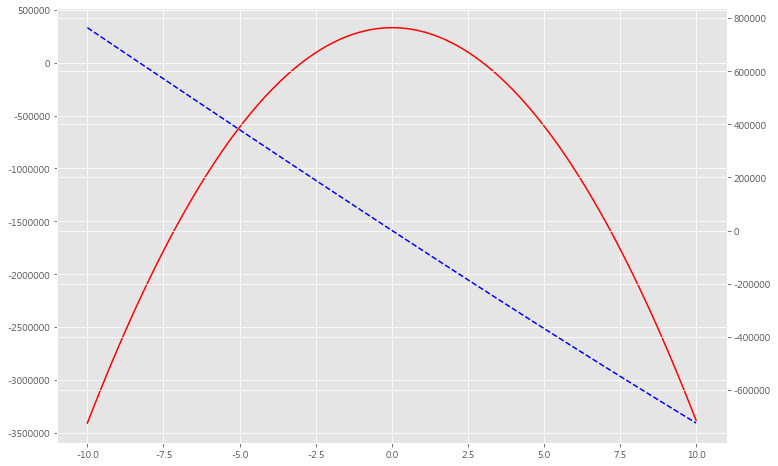

In [787]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.plot(x, y[:,0], color='red')
ax2.plot(x, y[:,1], '--', color='blue')
plt.show()

In [136]:
x_pred = A@x_prev+B
P_pred = A@P_prev@A.T+Q
z_meas = data[0]

z_pred = H@x_pred
v = z_meas-z_pred
F = H@P_pred@H.T+R
F_inv = inv(F)
K = P_pred@H.T@F_inv
x_update = x_pred+K@v
P_update = P_pred-K@H@P_pred
detF = det(F)
if detF <= 0:
    detF = 1e-70
    print('Warning : dF <= 0 인 경우가 있습니다.')
logL = -0.5*np.log(2*np.pi)-0.5*np.log(detF)-0.5*v.T@F_inv@v

####################
dx_prev1, dx_prev2, dx_prev3 = dx_prev
dP_prev11, dP_prev12, dP_prev13 = dP_prev[0]
dP_prev21, dP_prev22, dP_prev23 = dP_prev[1]
dP_prev31, dP_prev32, dP_prev33 = dP_prev[2]

# dH/dλ
dH_dlambda = np.array([[0, np.exp(-lambda_*t)/lambda_-(1-np.exp(-lambda_*t))/(lambda_*t)**2, np.exp(-lambda_*t)/lambda_-(1-np.exp(-lambda_*t))/(lambda_*t)**2+t*np.exp(-lambda_*t)] for t in tau])

# dz_pred/dλ
dz_pred_dlambda = dH_dlambda@x_pred

# dv/dλ
dv_dlambda = -dz_pred_dlambda

# dF/dλ
dF_dlambda = (dH_dlambda@P_pred@H.T+H@P_pred@dH_dlambda.T)

# dlogL/dλ
dlogL_dlambda = -0.5*np.trace(F_inv@dF_dlambda)-0.5*(dv_dlambda.T@F_inv@v+v.T@(-F_inv@dF_dlambda@F_inv)@v+v.T@F_inv@dv_dlambda)

# dK/dλ
dK_dlambda = P_pred@(dH_dlambda.T@F_inv+H.T@-F_inv@dF_dlambda@F_inv)

# dx_update/dλ
dx_update_dlambda = dK_dlambda@v+K@dv_dlambda

# dP_update/dλ
dP_update_dlambda = -(dK_dlambda@H+K@dH_dlambda)@P_pred

# Total
dx_update_dx_prev = dx_update_dx_prev1*dx_prev1+dx_update_dx_prev2*dx_prev2+dx_update_dx_prev3*dx_prev3
dP_update_dP_prev = dP_update_dP_prev11*dP_prev11+dP_update_dP_prev12*dP_prev12+dP_update_dP_prev13*dP_prev13 \
    + dP_update_dP_prev21*dP_prev21+dP_update_dP_prev22*dP_prev22+dP_update_dP_prev13*dP_prev13 \
    + dP_update_dP_prev31*dP_prev31+dP_update_dP_prev32*dP_prev32+dP_update_dP_prev33*dP_prev33

dlogL_dx_prev = dlogL_dx_prev1*dx_prev1+dlogL_dx_prev2*dx_prev2+dlogL_dx_prev3*dx_prev3

dlogL_dP_prev = dlogL_dP_prev11*dP_prev11+dlogL_dP_prev12*dP_prev12+dlogL_dP_prev13*dP_prev13 \
    + dlogL_dP_prev21*dP_prev21+dlogL_dP_prev22*dP_prev22+dlogL_dP_prev23*dP_prev23 \
    + dlogL_dP_prev31*dP_prev31+dlogL_dP_prev32*dP_prev32+dlogL_dP_prev33*dP_prev33

dlogL = dlogL_dlambda + dlogL_dx_prev + dlogL_dP_prev

dx_update = dx_update_dlambda + dx_update_dx_prev
dP_update = dP_update_dlambda + dP_update_dP_prev
####################

logL_sum += logL
x_prev, P_prev = x_update, P_update

dlogL_sum += dlogL
dx_prev, dP_prev = dx_update, dP_update

NameError: name 'dx_update_dx_prev1' is not defined

In [64]:
logL_sum = 0
dlogL_sum = 0
for i in range(len(data)):
    x_pred = A@x_prev+B
    P_pred = A@P_prev@A.T+Q
    z_meas = data[i]
    
    z_pred = H@x_pred
    v = z_meas-z_pred
    F = H@P_pred@H.T+R
    F_inv = inv(F)
    K = P_pred@H.T@F_inv
    x_update = x_pred+K@v
    P_update = P_pred-K@H@P_pred
    detF = det(F)
    if detF <= 0:
        detF = 1e-70
        print('Warning : dF <= 0 인 경우가 있습니다.')
    logL = -0.5*np.log(2*np.pi)-0.5*np.log(detF)-0.5*v.T@F_inv@v
    
    ####################
    dx_prev1, dx_prev2, dx_prev3 = dx_prev
    dP_prev11, dP_prev12, dP_prev13 = dP_prev[0]
    dP_prev21, dP_prev22, dP_prev23 = dP_prev[1]
    dP_prev31, dP_prev32, dP_prev33 = dP_prev[2]

    # dH/dλ
    dH_dlambda = np.array([[0, np.exp(-lambda_*t)-(1-np.exp(-lambda_*t))/(t*lambda_**2), 2*np.exp(-lambda_*t)-(1-np.exp(-lambda_*t))/(t*lambda_**2)] for t in tau])

    # dz_pred/dλ
    dz_pred_dlambda = dH_dlambda@x_pred

    # dv/dλ
    dv_dlambda = -dz_pred_dlambda

    # dF/dλ
    dF_dlambda = (dH_dlambda@P_pred@H.T+H@P_pred@dH_dlambda.T)

    # dlogL/dλ
    dlogL_dlambda = -0.5*np.trace(F_inv@dF_dlambda)-0.5*(dv_dlambda.T@F_inv@v+v.T@(-F_inv@dF_dlambda@F_inv)@v+v.T@F_inv@dv_dlambda)

    # dK/dλ
    dK_dlambda = P_pred@(dH_dlambda.T@F_inv+H.T@-F_inv@dF_dlambda@F_inv)

    # dx_update/dλ
    dx_update_dlambda = dK_dlambda@v+K@dv_dlambda

    # dP_update/dλ
    dP_update_dlambda = -(dK_dlambda@H+K@dH_dlambda)@P_pred

    # Total
    dx_update_dx_prev = dx_update_dx_prev1*dx_prev1+dx_update_dx_prev2*dx_prev2+dx_update_dx_prev3*dx_prev3
    dP_update_dP_prev = dP_update_dP_prev11*dP_prev11+dP_update_dP_prev12*dP_prev12+dP_update_dP_prev13*dP_prev13 \
        + dP_update_dP_prev21*dP_prev21+dP_update_dP_prev22*dP_prev22+dP_update_dP_prev13*dP_prev13 \
        + dP_update_dP_prev31*dP_prev31+dP_update_dP_prev32*dP_prev32+dP_update_dP_prev33*dP_prev33

    dlogL_dx_prev = dlogL_dx_prev1*dx_prev1+dlogL_dx_prev2*dx_prev2+dlogL_dx_prev3*dx_prev3

    dlogL_dP_prev = dlogL_dP_prev11*dP_prev11+dlogL_dP_prev12*dP_prev12+dlogL_dP_prev13*dP_prev13 \
        + dlogL_dP_prev21*dP_prev21+dlogL_dP_prev22*dP_prev22+dlogL_dP_prev23*dP_prev23 \
        + dlogL_dP_prev31*dP_prev31+dlogL_dP_prev32*dP_prev32+dlogL_dP_prev33*dP_prev33

    dlogL = dlogL_dlambda + dlogL_dx_prev + dlogL_dP_prev

    dx_update = dx_update_dlambda + dx_update_dx_prev
    dP_update = dP_update_dlambda + dP_update_dP_prev
    ####################
    
    logL_sum += logL
    x_prev, P_prev = x_update, P_update
    
    dlogL_sum += dlogL
    dx_prev, dP_prev = dx_update, dP_update

In [8]:
# dx_pred/dx_prev
dx_pred_dx_prev1 = A@np.array([1,0,0])
dx_pred_dx_prev2 = A@np.array([0,1,0])
dx_pred_dx_prev3 = A@np.array([0,0,1])

# dz_pred/dx_prev
dz_pred_dx_prev1 = H@dx_pred_dx_prev1
dz_pred_dx_prev2 = H@dx_pred_dx_prev2
dz_pred_dx_prev3 = H@dx_pred_dx_prev3

# dv/dx_prev
dv_dx_prev1 = -dz_pred_dx_prev1
dv_dx_prev2 = -dz_pred_dx_prev2
dv_dx_prev3 = -dz_pred_dx_prev3

# dlogL/dx_prev
dlogL_dx_prev1 = -0.5*(dv_dx_prev1.T@F_inv@v+v.T@F_inv@dv_dx_prev1)
dlogL_dx_prev2 = -0.5*(dv_dx_prev2.T@F_inv@v+v.T@F_inv@dv_dx_prev2)
dlogL_dx_prev3 = -0.5*(dv_dx_prev3.T@F_inv@v+v.T@F_inv@dv_dx_prev3)

# dx_update/dx_prev
dx_update_dx_prev1 = dx_pred_dx_prev1+K@dv_dx_prev1
dx_update_dx_prev2 = dx_pred_dx_prev2+K@dv_dx_prev2
dx_update_dx_prev3 = dx_pred_dx_prev3+K@dv_dx_prev3

In [10]:
# dP_pred/dP_prev
dP_pred_dP_prev11 = A@np.array([[1,0,0],[0,0,0],[0,0,0]])
dP_pred_dP_prev12 = A@np.array([[0,1,0],[0,0,0],[0,0,0]])
dP_pred_dP_prev13 = A@np.array([[0,0,1],[0,0,0],[0,0,0]])
dP_pred_dP_prev21 = A@np.array([[0,0,0],[1,0,0],[0,0,0]])
dP_pred_dP_prev22 = A@np.array([[0,0,0],[0,1,0],[0,0,0]])
dP_pred_dP_prev23 = A@np.array([[0,0,0],[0,0,1],[0,0,0]])
dP_pred_dP_prev31 = A@np.array([[0,0,0],[0,0,0],[1,0,0]])
dP_pred_dP_prev32 = A@np.array([[0,0,0],[0,0,0],[0,1,0]])
dP_pred_dP_prev33 = A@np.array([[0,0,0],[0,0,0],[0,0,1]])

# dF/dP_prev
dF_pred_dP_prev11 = H@dP_pred_dP_prev11@H.T
dF_pred_dP_prev12 = H@dP_pred_dP_prev12@H.T
dF_pred_dP_prev13 = H@dP_pred_dP_prev13@H.T
dF_pred_dP_prev21 = H@dP_pred_dP_prev21@H.T
dF_pred_dP_prev22 = H@dP_pred_dP_prev22@H.T
dF_pred_dP_prev23 = H@dP_pred_dP_prev23@H.T
dF_pred_dP_prev31 = H@dP_pred_dP_prev31@H.T
dF_pred_dP_prev32 = H@dP_pred_dP_prev32@H.T
dF_pred_dP_prev33 = H@dP_pred_dP_prev33@H.T

# dlogL/dP_prev
dlogL_dP_prev11 = -0.5*np.trace(F_inv@dF_pred_dP_prev11)-0.5*v.T@(-F_inv@dF_pred_dP_prev11@F_inv)@v
dlogL_dP_prev12 = -0.5*np.trace(F_inv@dF_pred_dP_prev12)-0.5*v.T@(-F_inv@dF_pred_dP_prev12@F_inv)@v
dlogL_dP_prev13 = -0.5*np.trace(F_inv@dF_pred_dP_prev13)-0.5*v.T@(-F_inv@dF_pred_dP_prev13@F_inv)@v
dlogL_dP_prev21 = -0.5*np.trace(F_inv@dF_pred_dP_prev21)-0.5*v.T@(-F_inv@dF_pred_dP_prev21@F_inv)@v
dlogL_dP_prev22 = -0.5*np.trace(F_inv@dF_pred_dP_prev22)-0.5*v.T@(-F_inv@dF_pred_dP_prev22@F_inv)@v
dlogL_dP_prev23 = -0.5*np.trace(F_inv@dF_pred_dP_prev23)-0.5*v.T@(-F_inv@dF_pred_dP_prev23@F_inv)@v
dlogL_dP_prev31 = -0.5*np.trace(F_inv@dF_pred_dP_prev31)-0.5*v.T@(-F_inv@dF_pred_dP_prev31@F_inv)@v
dlogL_dP_prev32 = -0.5*np.trace(F_inv@dF_pred_dP_prev32)-0.5*v.T@(-F_inv@dF_pred_dP_prev32@F_inv)@v
dlogL_dP_prev33 = -0.5*np.trace(F_inv@dF_pred_dP_prev33)-0.5*v.T@(-F_inv@dF_pred_dP_prev33@F_inv)@v

# dK/dP_prev
dK_pred_dP_prev11 = dP_pred_dP_prev11@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev11@F_inv)
dK_pred_dP_prev12 = dP_pred_dP_prev12@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev12@F_inv)
dK_pred_dP_prev13 = dP_pred_dP_prev13@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev13@F_inv)
dK_pred_dP_prev21 = dP_pred_dP_prev21@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev21@F_inv)
dK_pred_dP_prev22 = dP_pred_dP_prev22@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev22@F_inv)
dK_pred_dP_prev23 = dP_pred_dP_prev23@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev23@F_inv)
dK_pred_dP_prev31 = dP_pred_dP_prev31@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev31@F_inv)
dK_pred_dP_prev32 = dP_pred_dP_prev32@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev32@F_inv)
dK_pred_dP_prev33 = dP_pred_dP_prev33@H.T@F_inv+P_pred@H.T@(-F_inv@dF_pred_dP_prev33@F_inv)

# dP_update/d_prev
dP_update_dP_prev11 = dP_pred_dP_prev11-(dK_pred_dP_prev11@H@P_pred+K@H@dP_pred_dP_prev11)
dP_update_dP_prev12 = dP_pred_dP_prev12-(dK_pred_dP_prev12@H@P_pred+K@H@dP_pred_dP_prev12)
dP_update_dP_prev13 = dP_pred_dP_prev13-(dK_pred_dP_prev13@H@P_pred+K@H@dP_pred_dP_prev13)
dP_update_dP_prev21 = dP_pred_dP_prev21-(dK_pred_dP_prev21@H@P_pred+K@H@dP_pred_dP_prev21)
dP_update_dP_prev22 = dP_pred_dP_prev22-(dK_pred_dP_prev22@H@P_pred+K@H@dP_pred_dP_prev22)
dP_update_dP_prev23 = dP_pred_dP_prev23-(dK_pred_dP_prev23@H@P_pred+K@H@dP_pred_dP_prev23)
dP_update_dP_prev31 = dP_pred_dP_prev31-(dK_pred_dP_prev31@H@P_pred+K@H@dP_pred_dP_prev31)
dP_update_dP_prev32 = dP_pred_dP_prev32-(dK_pred_dP_prev32@H@P_pred+K@H@dP_pred_dP_prev32)
dP_update_dP_prev33 = dP_pred_dP_prev33-(dK_pred_dP_prev33@H@P_pred+K@H@dP_pred_dP_prev33)

In [43]:
# dA/dκ
dA_dkappa1 = np.array([[-dt, 0, 0], [0, 0, 0], [0, 0, 0]])
dA_dkappa2 = np.array([[0, 0, 0], [0, -dt, 0], [0, 0, 0]])
dA_dkappa3 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, -dt]])

# dB/dκ
dB_dkappa1 = np.array([theta1*dt, 0, 0])
dB_dkappa2 = np.array([0, theta2*dt, 0])
dB_dkappa3 = np.array([0, 0, theta3*dt])

# dx_pred/dκ
dx_pred_dkappa1 = dA_dkappa1@x_prev + dB_dkappa1
dx_pred_dkappa2 = dA_dkappa2@x_prev + dB_dkappa2
dx_pred_dkappa3 = dA_dkappa3@x_prev + dB_dkappa3

# dP_pred/dκ
dP_pred_dkappa1 = dA_dkappa1@P_prev@A.T + A@P_prev@dA_dkappa1.T
dP_pred_dkappa2 = dA_dkappa2@P_prev@A.T + A@P_prev@dA_dkappa2.T
dP_pred_dkappa3 = dA_dkappa3@P_prev@A.T + A@P_prev@dA_dkappa3.T

# dz_pred/dκ
dz_pred_dkappa1 = H@dx_pred_dkappa1
dz_pred_dkappa2 = H@dx_pred_dkappa2
dz_pred_dkappa3 = H@dx_pred_dkappa3

# dv/dκ
dv_dkappa1 = -dz_pred_dkappa1
dv_dkappa2 = -dz_pred_dkappa2
dv_dkappa3 = -dz_pred_dkappa3

# dF/dκ
dF_dkappa1 = H@dP_pred_dkappa1@H.T
dF_dkappa2 = H@dP_pred_dkappa2@H.T
dF_dkappa3 = H@dP_pred_dkappa3@H.T

# dlogL/dκ
dlogL_dkappa1 = -0.5*np.trace(F_inv@dF_dkappa1)-0.5*(dv_dkappa1.T@F_inv@v+v.T@(-F_inv@dF_dkappa1@F_inv)@v+v.T@F_inv@dv_dkappa1)
dlogL_dkappa2 = -0.5*np.trace(F_inv@dF_dkappa2)-0.5*(dv_dkappa2.T@F_inv@v+v.T@(-F_inv@dF_dkappa2@F_inv)@v+v.T@F_inv@dv_dkappa2)
dlogL_dkappa3 = -0.5*np.trace(F_inv@dF_dkappa3)-0.5*(dv_dkappa3.T@F_inv@v+v.T@(-F_inv@dF_dkappa3@F_inv)@v+v.T@F_inv@dv_dkappa3)

# dK/dκ
dK_dkappa1 = dP_pred_dkappa1@H.T@F_inv+P_pred@H.T@(-F_inv@dF_dkappa1@F_inv)
dK_dkappa2 = dP_pred_dkappa2@H.T@F_inv+P_pred@H.T@(-F_inv@dF_dkappa2@F_inv)
dK_dkappa3 = dP_pred_dkappa3@H.T@F_inv+P_pred@H.T@(-F_inv@dF_dkappa3@F_inv)

# dx_update/dκ
dx_update_dkappa1 = dx_pred_dkappa1+dK_dkappa1@v+K@dv_dkappa1
dx_update_dkappa2 = dx_pred_dkappa2+dK_dkappa1@v+K@dv_dkappa2
dx_update_dkappa3 = dx_pred_dkappa3+dK_dkappa1@v+K@dv_dkappa3

# dP_update/dκ
dP_update_dkappa1 = dP_pred_dkappa1-(dK_dkappa1@H@P_pred+K@H@dP_pred_dkappa1)
dP_update_dkappa2 = dP_pred_dkappa2-(dK_dkappa2@H@P_pred+K@H@dP_pred_dkappa2)
dP_update_dkappa3 = dP_pred_dkappa3-(dK_dkappa3@H@P_pred+K@H@dP_pred_dkappa3)

In [140]:
# dB/dθ
dB_dtheta1 = np.array([theta1*dt, 0, 0])
dB_dtheta2 = np.array([0, theta2*dt, 0])
dB_dtheta3 = np.array([0, 0, theta3*dt])

# dx_pred/dθ
dx_pred_dtheta1 = dB_dtheta1
dx_pred_dtheta2 = dB_dtheta2
dx_pred_dtheta3 = dB_dtheta3

# dz_pred/dθ
dz_pred_dtheta1 = H@dx_pred_dtheta1
dz_pred_dtheta2 = H@dx_pred_dtheta2
dz_pred_dtheta3 = H@dx_pred_dtheta3

# dv/dθ
dv_dtheta1 = -dz_pred_dtheta1
dv_dtheta2 = -dz_pred_dtheta2
dv_dtheta3 = -dz_pred_dtheta3

# dlogL/dθ
dlogL_dtheta1 = -0.5*(dv_dtheta1.T@F_inv@v+v.T@F_inv@dv_dtheta1)
dlogL_dtheta2 = -0.5*(dv_dtheta2.T@F_inv@v+v.T@F_inv@dv_dtheta2)
dlogL_dtheta3 = -0.5*(dv_dtheta3.T@F_inv@v+v.T@F_inv@dv_dtheta3)

# dx_update/dθ
dx_update_theta1 = dx_pred_dtheta1
dx_update_theta2 = dx_pred_dtheta2
dx_update_theta3 = dx_pred_dtheta3

array([ 0.e+00,  0.e+00, -4.e-05])

In [242]:
# dQ/dσ
dQ_dsigma11 = np.array([[2*sigma11, 0, 0], [0, 0, 0], [0, 0, 0]])
dQ_dsigma22 = np.array([[0, 0, 0], [0, 2*sigma22, 0], [0, 0, 0]])
dQ_dsigma33 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 2*sigma33]])

# dP_pred/dσ
dP_pred_dsigma11 = dQ_dsigma11
dP_pred_dsigma22 = dQ_dsigma22
dP_pred_dsigma33 = dQ_dsigma33

# dF/dσ
dF_dsigma11 = H@dP_pred_dsigma11@H.T
dF_dsigma22 = H@dP_pred_dsigma22@H.T
dF_dsigma33 = H@dP_pred_dsigma33@H.T

# dlogL/dσ
dlogL_dsigma11 = -0.5*np.trace(F_inv*dF_dsigma11)-0.5*v.T@(-F_inv@dF_dsigma11@F_inv)@v
dlogL_dsigma22 = -0.5*np.trace(F_inv*dF_dsigma22)-0.5*v.T@(-F_inv@dF_dsigma22@F_inv)@v
dlogL_dsigma33 = -0.5*np.trace(F_inv*dF_dsigma33)-0.5*v.T@(-F_inv@dF_dsigma33@F_inv)@v

# dK/dσ
dK_dsigma11 = P_pred@H.T@(-F_inv@dF_dsigma11@F_inv)
dK_dsigma22 = P_pred@H.T@(-F_inv@dF_dsigma22@F_inv)
dK_dsigma33 = P_pred@H.T@(-F_inv@dF_dsigma33@F_inv)

# dP_update/dσ
dP_update_dsigma11 = dP_pred_dsigma11-(dK_dsigma11@H@P_pred+K@H@dP_pred_dsigma11)
dP_update_dsigma22 = dP_pred_dsigma22-(dK_dsigma22@H@P_pred+K@H@dP_pred_dsigma22)
dP_update_dsigma33 = dP_pred_dsigma33-(dK_dsigma33@H@P_pred+K@H@dP_pred_dsigma33)

In [279]:
# dH/dλ
dH_dlambda = np.array([[0, np.exp(-lambda_*t)-(1-np.exp(-lambda_*t))/(t*lambda_**2), 2*np.exp(-lambda_*t)-(1-np.exp(-lambda_*t))/(t*lambda_**2)] for t in tau])

# dz_pred/dλ
dz_pred_dlambda = dH_dlambda@x_pred

# dv/dλ
dv_dlambda = -dz_pred_dlambda

# dF/dλ
dF_dlambda = (dH_dlambda@P_pred@H.T+H@P_pred@dH_dlambda.T)

# dlogL/dλ
dlogL_dlambda = -0.5*np.trace(F_inv@dF_dlambda)-0.5*(dv_dlambda.T@F_inv@v+v.T@(-F_inv@dF_dlambda@F_inv)@v+v.T@F_inv@dv_dlambda)

# dK/dλ
dK_dlambda = P_pred@(dH_dlambda.T@F_inv+H.T@-F_inv@dF_dlambda@F_inv)

# dx_update/dλ
dx_update_dlambda = dK_dlambda@v+K@dv_dlambda

# dP_update/dλ
dP_update_dlambda = -(dK_dlambda@H+K@dH_dlambda)@P_pred

# Total
dx_update_dx_prev = dx_update_dx_prev1*dx_prev1+dx_update_dx_prev2*dx_prev2+dx_update_dx_prev3*dx_prev3
dP_update_dP_prev = dP_update_dP_prev11*dP_prev11+dP_update_dP_prev12*dP_prev12+dP_update_dP_prev13*dP_prev13 \
    + dP_update_dP_prev21*dP_prev21+dP_update_dP_prev22*dP_prev22+dP_update_dP_prev13*dP_prev13 \
    + dP_update_dP_prev31*dP_prev31+dP_update_dP_prev32*dP_prev32+dP_update_dP_prev33*dP_prev33

dlogL_dx_prev = dlogL_dx_prev1*dx_prev1+dlogL_dx_prev2*dx_prev2+dlogL_dx_prev3*dx_prev3

dlogL_dP_prev = dlogL_dP_prev11*dP_prev11+dlogL_dP_prev12*dP_prev12+dlogL_dP_prev13*dP_prev13 \
    + dlogL_dP_prev21*dP_prev21+dlogL_dP_prev22*dP_prev22+dlogL_dP_prev23*dP_prev23 \
    + dlogL_dP_prev31*dP_prev31+dlogL_dP_prev32*dP_prev32+dlogL_dP_prev33*dP_prev33

dlogL = dlogL_dlambda + dlogL_dx_prev + dlogL_dP_prev

dx_prev1, dx_prev2, dx_prev3 = dx_update_dlambda+dx_update_dx_prev
dP_prev11, dP_prev12, dP_prev13 = dP_update_dlambda[0]+dP_update_dP_prev[0]
dP_prev21, dP_prev22, dP_prev23 = dP_update_dlambda[1]+dP_update_dP_prev[1]
dP_prev31, dP_prev32, dP_prev33 = dP_update_dlambda[2]+dP_update_dP_prev[2]

In [224]:
# dR/dε
dR_deps = np.identity(len(tau))*(2*eps)

# dF/dε
dF_deps = dR_deps

# dlogL/dε
dlogL_deps = -0.5*np.trace(F_inv@dF_deps)-0.5*v.T@(-F_inv@dF_deps@F_inv)@v

# dK/dε
dK_deps = P_pred@H.T@(-F_inv@dF_deps@F_inv)

# dx_update/dε
dx_update_deps = dK_deps@v

# dP_update/dε
dP_update_deps = -dK_deps@H@P_pred